<a href="https://colab.research.google.com/github/lucasflores/PermaLost/blob/main/PermaFrostProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Permafrost Project

## The Problem

Melt and thaw of ground leads to decay of 'soft' artifacts -> race to save these from decay/rot

## The Project

In this project I will use permafrost data provided by the European Space Agency's (ESA) Climate Change Initiative (CCI) Permafrost project.  It is derived from a thermal model driven and constrained by satellite data.

## The Data
Permafrost is an Essential Climate Variable (ECV) within the Global Climate Observing System (GCOS), which is characterized by subsurface temperatures and the depth of the seasonal thaw layer. Complementing ground-based monitoring networks, the Permafrost CCI project is establishing Earth Observation (EO) based products for the permafrost ECV spanning the last two decades. Since ground temperature and thaw depth cannot be directly observed from space-borne sensors, a variety of satellite and reanalysis data are combined in a ground thermal model. The algorithm uses remotely sensed data sets of Land Surface Temperature (MODIS LST/ ESA LST CCI) and landcover (ESA Landcover CCI) to drive the transient permafrost model CryoGrid CCI, which yields thaw depth and ground temperature at various depths, while ground temperature forms the basis for permafrost fraction.

### **GTD** Ground temp (by depth) - **GST**, **T1m**, **T2m**, **T5m**, and **T10m**
This corresponds to average annual ground temperatures and is provided for specific depths,
Ground Surface Temperature, 1 meter beneath surface, 2 meters beneath surface, 5 meters beneath surface, and 10 meters beneath surface.
  

### **PFR** Permafrost extent (fraction)
The boundary of permafrost can be defined as
1. The geographical boundary between the continuous and discontinuous permafrost zones.
2. The margin of a discrete body of permafrost.

A permafrost region is commonly subdivided into permafrost zones based on the proportion of the ground that is perennially cryotic. The basic subdivision in high latitudes is into zones of continuous permafrost and discontinuous permafrost. REFERENCES: Muller, 1943; Brown, 1967, 1978; Washburn, 1979; Pewe, 1983. Continuous permafrost is the major subdivision of a permafrost region in which permafrost occurs everywhere beneath the exposed land surface with the exception of widely scattered sites. Taliks associated with rivers and lakes may occur in the continuous permafrost zone. REFERENCE: Brown, 1970. Discontinuous permafrost corresponds to permafrost occurring in some areas beneath the exposed land
surface throughout a geographic region where other areas are free of permafrost. Discontinuous permafrost occurs between the continuous permafrost zone and the southern latitudinal limit of permafrost in lowlands. Depending on the scale of mapping, several subzones can often be
distinguished, based on the percentage (or fraction) of the land surface underlain by permafrost, as shown in the following table.

### **ALT** Active Layer Thickness
Active Layer Thickness is the thickness of the layer of the ground that is subject to annual thawing and freezing in areas underlain by permafrost. The thickness of the active layer depends on such factors as the ambient air temperature, vegetation, drainage, soil or rock type and total water content, snowcover, and degree and orientation of slope. As a rule, the active layer is thin in the High Arctic (it can be less than 15 cm) and becomes thicker farther south (1 m or more).
The thickness of the active layer can vary from year to year, primarily due to variations in the mean annual air temperature, distribution of soil moisture, and snowcover





### Project Package Dependencies  
- pandas 
- geopandas 
- matplotlib

### ML/Analysis algorithm note
* Geographic Weighted Regression seems to be a reasonable start for some predictive analysis via the mgwr python package (more details here https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-cd2LqaPqTSibIEHMiigreg)
* Might just be useful for interpolation. Not sure if I can do like a time series regression. 
* gwr/mgwr has a “bandwidth“ parameter which sets the “neighborhood” size to be used for the location based regression. Also it seems to apply some shooting which I should read up more on.  

## General Notes
### *04/05/22* 
* Data downloading, combing of separate PFR, ATL, and GTD files, and deleting nan and non Greenland data in dfs (most expensive/longest steps) takes about 1-1.5 hours.
* Downloads faster on google cola but not enough RAM to do row dropping computations. Trying to find smart ways to release RAM. Should check in indices of “”Greenland” lat/longs exist in some relatively close range that I can take advantage of so I don’t have to loop through every goddamn instance. 
* Want to implement a memory profiler as well. 

In [1]:
!pip install --upgrade geopandas
!pip install folium matplotlib mapclassify
!pip3 install pickle5
!pip install wget
#!pip install dtale

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 19.0 MB/s 
     |████████████████████████████████| 6.3 MB 79.4 MB/s 
     |████████████████████████████████| 16.7 MB 69.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 35.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=058cd63d74f73fde4a2e7017fea4c30df881edb6dfe325ffd5c4ce699fdd17e8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [1]:
import os
import pandas as pd
import sklearn
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle5 as pickle
import geopandas as gpd
from shapely.geometry import Point
import folium
import wget
import xarray as xr
import gc   #garbage collector interface
#import argparse
#import dtale
#import dtale.global_state as global_state
#global_state.set_chart_settings({'scatter_points': 15000, '3d_points': 40000})
#import dtale.app as dtale_app
#dtale_app.USE_COLAB = True

# Get The Data

In [ ]:
selectGreenland_to_pickle=True

years = ['2000','2001']

if selectGreenland_to_pickle :
  for year in years :
  #for year in ['1999']:
    ALT = "https://dap.ceda.ac.uk/neodc/esacci/permafrost/data/active_layer_thickness/L4/area4/pp/v03.0//ESACCI-PERMAFROST-L4-ALT-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-"+year+"-fv03.0.nc"
    PFR = "https://dap.ceda.ac.uk/neodc/esacci/permafrost/data/permafrost_extent/L4/area4/pp/v03.0//ESACCI-PERMAFROST-L4-PFR-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-"+year+"-fv03.0.nc"
    GTD = "https://dap.ceda.ac.uk/neodc/esacci/permafrost/data/ground_temperature/L4/area4/pp/v03.0//ESACCI-PERMAFROST-L4-GTD-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-"+year+"-fv03.0.nc"

    wget.download(GTD, './')
    dsGTD = xr.open_dataset('ESACCI-PERMAFROST-L4-GTD-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-'+year+'-fv03.0.nc')
    os.remove('ESACCI-PERMAFROST-L4-GTD-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-'+year+'-fv03.0.nc')
    dfGTD = dsGTD[['GST','T1m','T2m','T5m','T10m']].to_dataframe() #RAM destroyer
    del dsGTD    # No longer need dataset
    %reset -f Out   # Release memory
    gc.collect() # Collect memory garbage
    dfGTD = dfGTD.reset_index()
    # Restrict to Lat/Long containing Greenland only
    #print(dfGTD.iloc[72000000:113000000]) #Selects Longs -4.042571e+05 to -2.977496e+06
    dfGTD = dfGTD.iloc[72000000:113000000] #Selects Lats between -2500000.0 and -274000.0
    %reset -f Out
    gc.collect() 
    dfGTD.drop(dfGTD[dfGTD['x'] < -2499489.0].index, inplace=True)
    dfGTD.drop(dfGTD[dfGTD['x'] > -285781.1].index, inplace=True)
    %reset -f Out
    gc.collect() 

    wget.download(PFR, './')
    dsPFR = xr.open_dataset('ESACCI-PERMAFROST-L4-PFR-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-'+year+'-fv03.0.nc')
    os.remove('ESACCI-PERMAFROST-L4-PFR-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-'+year+'-fv03.0.nc')
    dfPFR = dsPFR.to_dataframe()
    del dsPFR
    %reset -f Out
    gc.collect() 
    dfPFR = dfPFR.reset_index()
    dfPFR = dfPFR.iloc[40361213:65095962] # x: -2.499489e+06 to -2.857811e+05
    %reset -f Out
    gc.collect() 
    dfPFR.drop(dfPFR[dfPFR['y'] < -2900000.0].index, inplace=True)
    dfPFR.drop(dfPFR[dfPFR['y'] > -420000.0].index, inplace=True)
    %reset -f Out
    gc.collect() 
  
    wget.download(ALT, './')
    dsALT = xr.open_dataset('ESACCI-PERMAFROST-L4-ALT-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-'+year+'-fv03.0.nc')
    os.remove('ESACCI-PERMAFROST-L4-ALT-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-'+year+'-fv03.0.nc')
    dfALT = dsALT.to_dataframe()
    del dsALT
    %reset -f Out
    gc.collect() 
    dfALT = dfALT.reset_index()
    dfALT = dfALT.iloc[40361213:65095962]
    %reset -f Out
    gc.collect() 
    dfALT.drop(dfALT[dfALT['y'] < -2900000.0].index, inplace=True)
    dfALT.drop(dfALT[dfALT['y'] > -420000.0].index, inplace=True)
    %reset -f Out
    gc.collect() 
  
    #Concat datasets together 
    dfGreenland_PFR_ALT = pd.concat([dfPFR, dfALT['ALT']], axis=1)
    del dfPFR
    del dfALT
    dfGreenland_PFR_ALT = dfGreenland_PFR_ALT.dropna(subset=['PFR','ALT'], how='all')
    dfGTD = dfGTD.dropna(subset=['GST','T1m','T2m','T5m','T10m'], how='all')
    dfGreenland_PFR_ALT.to_pickle("Greenland_PFR_ALT_noNANallColumns_"+year+"_Pickle.pkl")
    dfGTD.to_pickle("Greenland_GTD_noNANallColumns_"+year+"_Pickle.pkl")
    %reset -f Out
    gc.collect() 
    #gdfGreenland = gpd.GeoDataFrame( dfGreenland, geometry=gpd.points_from_xy(dfGreenland.x, dfGreenland.y))

del dfGreenland_PFR_ALT
del dfGTD
%reset -f Out
gc.collect() 

%ls

Flushing output cache (0 entries)
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  release, please run `%reset?` for details
Don't know how to reset  memory, please run `%reset?` for details


In [4]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
%ls /content/drive
# copy it there
#!cp example.txt /content/drive/MyDrive

Mounted at /content/drive
MyDrive/


In [2]:
%ls /content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/

Greenland_GTD_noNANallColumns_1997_Pickle.pkl
Greenland_GTD_noNANallColumns_1998_Pickle.pkl
Greenland_GTD_noNANallColumns_1999_Pickle.pkl
Greenland_PFR_ALT_noNANallColumns_1997_Pickle.pkl
Greenland_PFR_ALT_noNANallColumns_1998_Pickle.pkl
Greenland_PFR_ALT_noNANallColumns_1999_Pickle.pkl


In [4]:
with open('/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/Greenland_PFR_ALT_noNANallColumns_1997_Pickle.pkl', 'rb') as pickle_file:
    dfGreenland_1997 = pickle.load(pickle_file)
with open('/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/Greenland_PFR_ALT_noNANallColumns_1998_Pickle.pkl', 'rb') as pickle_file:
    dfGreenland_1998 = pickle.load(pickle_file)
with open('/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/Greenland_PFR_ALT_noNANallColumns_1999_Pickle.pkl', 'rb') as pickle_file:
    dfGreenland_1999 = pickle.load(pickle_file)

In [5]:
# Convert DataFrame to a geoDataFrame
gdfGreenland_1997 = gpd.GeoDataFrame( dfGreenland_1997, geometry=gpd.points_from_xy(dfGreenland_1997.x, dfGreenland_1997.y))
gdfGreenland_1998 = gpd.GeoDataFrame( dfGreenland_1998, geometry=gpd.points_from_xy(dfGreenland_1998.x, dfGreenland_1998.y))
gdfGreenland_1999 = gpd.GeoDataFrame( dfGreenland_1999, geometry=gpd.points_from_xy(dfGreenland_1999.x, dfGreenland_1999.y))

In [ ]:
#dtale.show(gdfGreenland_1998 )

In [6]:
del dfGreenland_1997
del dfGreenland_1998
del dfGreenland_1999
%reset -f Out
gc.collect()

Flushing output cache (0 entries)


0

In [7]:
gdfGreenland_1997['time'] = gdfGreenland_1997['time'].apply(lambda x: x.year) # Converts Timestamp object to just year ints
gdfGreenland_1998['time'] = gdfGreenland_1998['time'].apply(lambda x: x.year) # Converts Timestamp object to just year ints
gdfGreenland_1999['time'] = gdfGreenland_1999['time'].apply(lambda x: x.year) # Converts Timestamp object to just year ints

In [11]:
gdfGreenland = pd.concat([gdfGreenland_1997, gdfGreenland_1998, gdfGreenland_1999], axis=0)

In [12]:
del gdfGreenland_1997
del gdfGreenland_1998
del gdfGreenland_1999
%reset -f Out
gc.collect()

Flushing output cache (1 entries)


0

In [13]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

attributes = ["PFR", "ALT"]
X = gdfGreenland[attributes]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X)
print(X_scaled)

            PFR   ALT
40361214  100.0  0.37
40361215  100.0  0.33
40361216  100.0  0.33
40361217  100.0  0.10
40361218  100.0  0.11
...         ...   ...
65085605   43.0  1.30
65085606   57.0  1.05
65085607   86.0  1.03
65095959   43.0  0.77
65095960   86.0  1.08

[1743726 rows x 2 columns]
[[ 0.31901532  0.10635175]
 [ 0.31901532 -0.03097247]
 [ 0.31901532 -0.03097247]
 ...
 [-0.44424516  2.3722    ]
 [-2.7885454   1.4795932 ]
 [-0.44424516  2.543855  ]]


In [3]:
gdfGreenland_scaled = pd.DataFrame(X_scaled, columns = attributes)
scatter_matrix(gdfGreenland[attributes], figsize=(12, 8))

plt.show()
#ax = gdfGreenland.plot(figsize=(11,10), alpha=0.9)
#ax.set_ylim([-2.2e6, -1.9e6])
#ax.set_xlim([-1.1e6, -0.8e6]

NameError: ignored

In [16]:
gdfGreenland.head() 

,time,x,y,polar_stereographic,PFR,ALT,geometry
40361214,1997,-2.499489e+06,-722089.666285,-2147483647,100.0,0.37,POINT (-2499489.284 -722089.666)
40361215,1997,-2.499489e+06,-723016.291719,-2147483647,100.0,0.33,POINT (-2499489.284 -723016.292)
40361216,1997,-2.499489e+06,-723942.917152,-2147483647,100.0,0.33,POINT (-2499489.284 -723942.917)
40361217,1997,-2.499489e+06,-724869.542585,-2147483647,100.0,0.10,POINT (-2499489.284 -724869.543)
40361218,1997,-2.499489e+06,-725796.168018,-2147483647,100.0,0.11,POINT (-2499489.284 -725796.168)


In [34]:
gdfGreenland[(gdfGreenland['x'] == -2499489.284021524) & (gdfGreenland['y'] == -722089.6662854771)]

,time,x,y,polar_stereographic,PFR,ALT,geometry
40361214,1997,-2.499489e+06,-722089.666285,-2147483647,100.0,0.37,POINT (-2499489.284 -722089.666)
40361214,1998,-2.499489e+06,-722089.666285,-2147483647,100.0,0.50,POINT (-2499489.284 -722089.666)
40361214,1999,-2.499489e+06,-722089.666285,-2147483647,100.0,0.34,POINT (-2499489.284 -722089.666)


In [17]:
# Need to construct a time series dataset, i.e. concat 1997, 1998, and 1999. Might make sense to change time values to ints, i.e. 1998-01-01 to 1998
# Want to be able to input a a year and location ('time','x','y') and output predictions for 'ALT','PFR','GST',and 'Txm'


from sklearn import linear_model
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Let's see how correlated these variables are

X = gdfGreenland[['time','x', 'y']]
#y_GST = gdfGreenland['GST']
#y_ALT = gdfGreenland['ALT']
y_PFR = gdfGreenland['PFR']
#y_T1m = gdfGreenland['T1m']
#y_T2m = gdfGreenland['T2m']
#y_T5m = gdfGreenland['T5m']
#y_T10m = gdfGreenland['T10m']

# splitting the data
#X_train, X_test, y_train, y_test = train_test_split(X, y_PFR, test_size = 0.2, random_state = 42)

#regr_GST = linear_model.LinearRegression()
#regr_GST.fit(X_train, y_train)

#regr_ALT = linear_model.LinearRegression()
#regr_ALT.fit(X, y_ALT)
#regr_PFR = linear_model.LinearRegression()
#regr_PFR.fit(X, y_PFR)
#regr_T1m = linear_model.LinearRegression()
#regr_T1m.fit(X, y_T1m)
#regr_T2m = linear_model.LinearRegression()
#regr_T2m.fit(X, y_T2m)
#regr_T5m = linear_model.LinearRegression()
#regr_T5m.fit(X, y_T5m)
#regr_T10m = linear_model.LinearRegression()
#regr_T10m.fit(X, y_T10m)

#print('GST: ' + str(regr_GST.predict([[Year, Lat, Long])))

#def IsItMelty(Year, Lat, Long) :
#  print('GST: ' + str(regr_GST.predict([[Year, Lat, Long])))
#  print('ALT: ' + str(regr_ALT.predict([[Year, Lat, Long])))
#  print('PFR: ' + str(regr_PFR.predict([[Year, Lat, Long])))
#  print('T1m: ' + str(regr_T1m.predict([[Year, Lat, Long])))
#  print('T2m: ' + str(regr_T2m.predict([[Year, Lat, Long])))
#  print('T5m: ' + str(regr_T5m.predict([[Year, Lat, Long])))
#  print('T10m: ' + str(regr_T10m.predict([[Year, Lat, Long])))

In [20]:
X_train.head()

,time,x,y
41096488,1999,-2.433699e+06,-9.176076e+05
42255857,1997,-2.329917e+06,-7.628612e+05
44978424,1999,-2.086214e+06,-5.108191e+05
44265431,1999,-2.150151e+06,-1.774736e+06
47494115,1999,-1.861044e+06,-4.292760e+05


In [19]:
y_train.head()

41096488    100.0
42255857    100.0
44978424    100.0
44265431     71.0
47494115    100.0
Name: PFR, dtype: float32

In [ ]:
%mkdir GlacierBaseMap
%mkdir CoastLineBaseMap

In [ ]:
%ls

In [ ]:
# Upload Greenland_noNANallColumns_2018_Pickle.pkl here
#from google.colab import files
#uploaded = files.upload()

In [ ]:
print(gdfGreenland_unpickle.head(10))

In [ ]:
print(gdfGreenland.head())
print(gdfGreenland.tail())

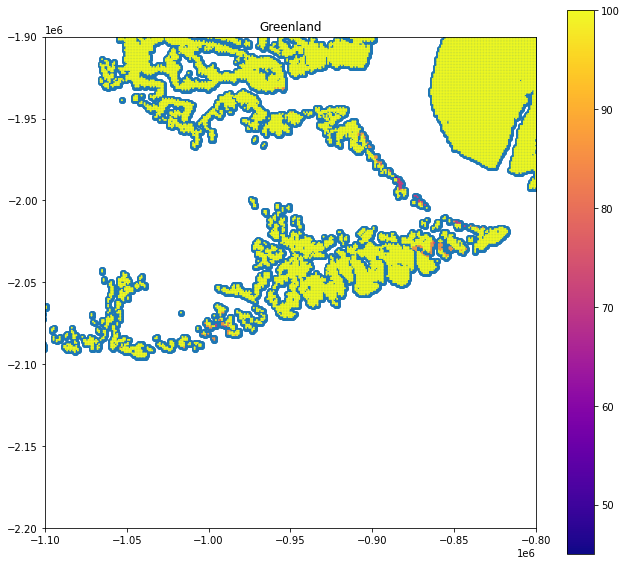

In [ ]:
#glaciers = gpd.read_file('./GlacierBaseMap/jf791qw8489.shp') #2017 dataset
#glaciers = glaciers[glaciers.cenlat > 67.9][glaciers.cenlat < 70.83][glaciers.cenlon > -31.5][glaciers.cenlon < -20.57]

#coastlines = gpd.read_file('./CoastLineBaseMap/sd368wz2435.shp')
#glaciers = glaciers.to_crs("EPSG:3995") # world.to_crs(epsg=3395) would also work
#coastlines = coastlines.to_crs("EPSG:3995") # world.to_crs(epsg=3395) would also work

gdfGreenland.crs = "EPSG:3995"
#gdfGreenland1997.crs = "EPSG:3995"

ax = gdfGreenland.plot(figsize=(11,10), alpha=0.9)
#ax = glaciers.plot(figsize=(11,10), alpha=0.9)
ax.set_title("Greenland")
ax.set_ylim([-2.2e6, -1.9e6])
ax.set_xlim([-1.1e6, -0.8e6])

#coastlines.boundary.plot(ax=ax,color='black', alpha=0.6, zorder=1)
#gdfGreenland_unpickle.plot(ax=ax, column='T10m', markersize=0.5, cmap="plasma", legend=True, alpha=0.7)
#gdfGreenland_unpickle.plot(ax=ax, column='GST ', markersize=0.5, cmap="plasma", vmin=45.0, legend=True, alpha=0.7)
#gdfGreenland1997.plot(ax=ax, column='PFR', markersize=0.5, cmap="plasma", vmin=45.0, legend=True, alpha=0.7)
gdfGreenland.plot(ax=ax, column="PFR", markersize=0.5, cmap="plasma", vmin=45.0, legend=True, alpha=0.7)

plt.show()

In [ ]:
map = folium.Map(location = [13.406,80.110], tiles = "Stamen Terrain", zoom_start = 9)
map

In [ ]:
gdfGreenland.head()
gdfGreenland.plot(ax=ax, column='PFR', markersize=0.5, alpha=0.7)
plt.show()

In [ ]:
print(gdfGreenland.crs)